In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import seaborn as sns
from scipy.stats import chi2_contingency, randint, uniform
from sklearn.preprocessing import LabelEncoder, StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold, RandomizedSearchCV, validation_curve
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, f1_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,VotingClassifier, BaggingClassifier
from sklearn.base import clone
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict
import joblib
import os
from imblearn.pipeline import Pipeline


RANDOM_STATE = 42

In [3]:
#Data sets despues de eliminar variables de alta correlacion
Data_class_filtrado = pd.read_csv("../data/wine_data_train_classification_filtrado.csv")
Data_class_filtrado = pd.DataFrame(Data_class_filtrado)

Data_regres_filtrado = pd.read_csv("../data/wine_data_train_regression_filtrado.csv")
Data_regres_filtrado = pd.DataFrame(Data_regres_filtrado)

print(f"\n🔹 Columnas en clasificacion:\n{Data_class_filtrado.columns.tolist()}")
print(f"\n🔹 Columnas en regresion:\n{Data_regres_filtrado.columns.tolist()}")



🔹 Columnas en clasificacion:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'type', 'quality_category']

🔹 Columnas en regresion:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


### Separar Variables y Target
Se realizó la separación de los datos en conjuntos de **entrenamiento (80%)** y **prueba (20%)**
con el objetivo de evaluar el rendimiento real de los modelos y evitar el sobreajuste.

- Para la **clasificación**, se usó la variable `quality_category` como objetivo (`y_class_filtrado`).
- Para la **regresión**, se usó la variable `quality` como objetivo (`y_regres_filtrado`).

Además, se aplicó el parámetro **`stratify`**, que permite mantener la misma proporción de clases
en los conjuntos de entrenamiento y prueba, garantizando una representación equilibrada del target.

### Escalamiento de variables
Para el preprocesamiento de los datos, se aplicó el **RobustScaler**, un método que transforma
las variables eliminando la mediana y escalando según el rango intercuartílico (IQR).

- **Ventaja:** es menos sensible a los **valores atípicos (outliers)** en comparación con otros escaladores
como `StandardScaler` o `MinMaxScaler`, lo cual mejora la estabilidad de los modelos.

- **Clasificación:** se utilizó `RobustScaler` porque los datos presentan cierta variabilidad
y no requieren un escalado estricto.
- **Regresión:** se aplicó el mismo escalador, dado que el objetivo `quality` puede verse afectado
por variables con diferente escala y la presencia de posibles valores extremos.

In [4]:
#separar variables de target
X_class_filtrado = Data_class_filtrado.drop(columns=['quality_category'])
y_class_filtrado = Data_class_filtrado['quality_category']

# Crear nueva variable binaria solo clase medium y no medium
y_binaria = y_class_filtrado.copy()
y_bin_class = y_binaria.replace({0: 'no_medium', 2: 'no_medium', 1: 'medium'})

# Crear nueva variable binaria clase low y high
mask_lh = y_class_filtrado.isin([0, 2])
X_LowHigh_class = X_class_filtrado.loc[mask_lh].copy()
y_LowHigh_class = y_class_filtrado.loc[mask_lh].replace({0: 'high', 2: 'low'}).copy()  # o deja ints {0,2}

X_regres_filtrado = Data_regres_filtrado.drop(columns=['quality'])
y_regres_filtrado = Data_regres_filtrado['quality']

#------------------------------------------------------------------------
#Dividir los datos para clasificacion (Medium - No Medium) y (Low - High)
#------------------------------------------------------------------------
X_train_clf, X_test_clf, y_train_clf, y_test_clf= train_test_split(
    X_class_filtrado,
    y_class_filtrado, 
    test_size=0.2,
    random_state= RANDOM_STATE,
    stratify=y_bin_class
)


X_train_clf_Medi, X_test_clf_Medi, y_train_clf_Medi, y_test_clf_Medi= train_test_split(
    X_class_filtrado,
    y_bin_class, #cambio Medium - No Medium
    test_size=0.2,
    random_state= RANDOM_STATE,
    stratify=y_bin_class
)

X_train_clf_LH, X_test_clf_LH, y_train_clf_LH, y_test_clf_LH= train_test_split(
    X_LowHigh_class,
    y_LowHigh_class, #cambio Low - High class
    test_size=0.2,
    random_state= RANDOM_STATE,
    stratify=y_LowHigh_class
)

#----------------------------------------
#Dividir los datos para regresion
#----------------------------------------
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_regres_filtrado,
    y_regres_filtrado,
    test_size=0.2,
    random_state= RANDOM_STATE,
    stratify=y_regres_filtrado
)

#----------------------------------------
#escalar datos de entrenamiento
#----------------------------------------

scaler_clf = RobustScaler()
X_train_clf_scal = scaler_clf.fit_transform(X_train_clf) #todas las clases
X_test_clf_scal = scaler_clf.transform(X_test_clf) #todas las clases

X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf_Medi)
X_test_clf_scaled = scaler_clf.transform(X_test_clf_Medi)

X_train_clf_scaled_LH = scaler_clf.fit_transform(X_train_clf_LH)
X_test_clf_scaled_LH = scaler_clf.transform(X_test_clf_LH)

scaler_reg = RobustScaler()
X_train_reg_scaled = scaler_clf.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_clf.transform(X_test_reg)


# Clasificación general (todas las clases)
X_train_clf_scal = pd.DataFrame(X_train_clf_scal, columns=X_train_clf.columns)
X_test_clf_scal  = pd.DataFrame(X_test_clf_scal,  columns=X_test_clf.columns)

# Clasificación Medium vs No Medium
X_train_clf_scaled = pd.DataFrame(X_train_clf_scaled, columns=X_train_clf_Medi.columns)
X_test_clf_scaled  = pd.DataFrame(X_test_clf_scaled,  columns=X_test_clf_Medi.columns)

# Clasificación Low vs High
X_train_clf_scaled_LH = pd.DataFrame(X_train_clf_scaled_LH, columns=X_train_clf_LH.columns)
X_test_clf_scaled_LH  = pd.DataFrame(X_test_clf_scaled_LH,  columns=X_test_clf_LH.columns)

# Regresión
X_train_reg_scaled = pd.DataFrame(X_train_reg_scaled, columns=X_train_reg.columns)
X_test_reg_scaled  = pd.DataFrame(X_test_reg_scaled,  columns=X_test_reg.columns)

### Analisis de balance de clases
Al analizar la distribución de clases en el conjunto de entrenamiento, se observa que existe un desequilibrio significativo entre las categorías de la variable objetivo (`quality_category`).

- La clase **1 (Medium)** representa la mayoría de las observaciones.
- Las clases **0 (High)** y **2 (Low)** tienen una menor frecuencia.

Este desequilibrio puede afectar el desempeño de los modelos de clasificación, especialmente en métricas como *accuracy*, que podría ser engañosa si el modelo aprende a favorecer la clase mayoritaria.

Conteo de clases en train:
 quality_category
medium       3580
no_medium    1097
Name: count, dtype: int64

Porcentaje de clases en train (%):
 quality_category
medium       76.54
no_medium    23.46
Name: proportion, dtype: float64


C:\Users\ana.bolanos\AppData\Local\Temp\ipykernel_2956\1867384272.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="crest")


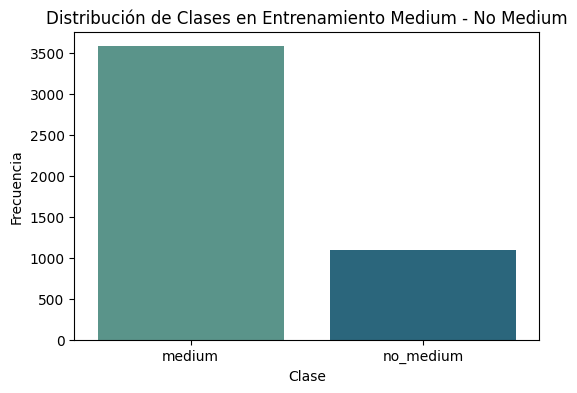

Conteo de clases en train:
 quality_category
high    919
low     177
Name: count, dtype: int64

Porcentaje de clases en train (%):
 quality_category
high    83.85
low     16.15
Name: proportion, dtype: float64


C:\Users\ana.bolanos\AppData\Local\Temp\ipykernel_2956\1867384272.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts_LH.index, y=class_counts_LH.values, palette="crest")


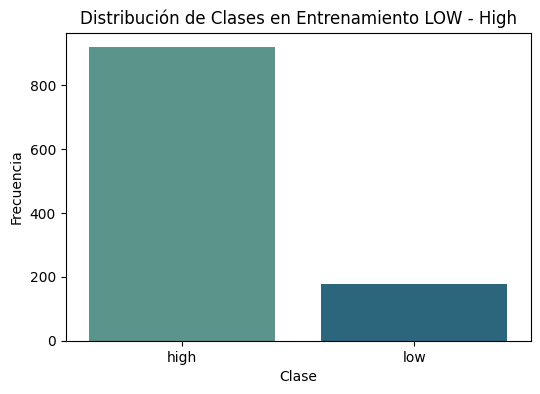

In [5]:
# Distribución de las clases en y_train de clasificacion Medium - No Medium
class_counts = y_train_clf_Medi.value_counts()
class_percent = y_train_clf_Medi.value_counts(normalize=True) * 100

print("Conteo de clases en train:\n", class_counts)
print("\nPorcentaje de clases en train (%):\n", class_percent.round(2))

# Visualización
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="crest")
plt.title("Distribución de Clases en Entrenamiento Medium - No Medium")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()

# Distribución de las clases en y_train de clasificacion Low - High
class_counts_LH = y_train_clf_LH.value_counts()
class_percent_LH = y_train_clf_LH.value_counts(normalize=True) * 100

print("Conteo de clases en train:\n", class_counts_LH)
print("\nPorcentaje de clases en train (%):\n", class_percent_LH.round(2))

# Visualización
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts_LH.index, y=class_counts_LH.values, palette="crest")
plt.title("Distribución de Clases en Entrenamiento LOW - High")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()


### 🔄 Balanceo de Clases con SMOTE

En esta sección se aplica el método SMOTE para corregir el desbalance presente en las etiquetas del conjunto de entrenamiento.  
El objetivo es asegurar que el modelo no favorezca a la clase mayoritaria durante el entrenamiento.

- Se realiza el balanceo en tres escenarios de clasificación:
  1. **Medium vs No-Medium**
  2. **Low vs High**
  3. **Multiclase (todas las categorías)**

- Después de aplicar SMOTE, cada conjunto presenta un número similar de muestras por clase, lo que se verifica mediante:
  - Conteo de frecuencia por clase.
  - Visualización con gráficos de barras.

- Este balanceo permitirá que los modelos entrenados posteriormente:
  - Tengan una mayor capacidad para identificar correctamente las clases minoritarias.
  - Eviten sesgos hacia la clase predominante en los datos originales.

En general, el proceso asegura un conjunto de entrenamiento más representativo y adecuado para entrenar modelos de clasificación robustos.



Conteo de clases en train:
 target
medium       3580
no_medium    3580
Name: count, dtype: int64

Porcentaje de clases en train (%):
 target
medium       50.0
no_medium    50.0
Name: proportion, dtype: float64


C:\Users\ana.bolanos\AppData\Local\Temp\ipykernel_2956\1542733071.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="crest")


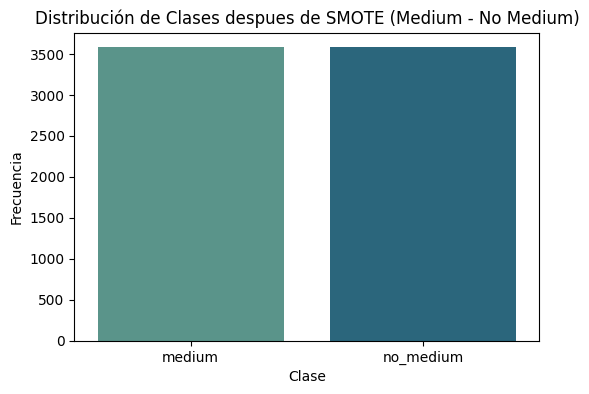

Conteo de clases en train:
 target
high    919
low     919
Name: count, dtype: int64

Porcentaje de clases en train (%):
 target
high    50.0
low     50.0
Name: proportion, dtype: float64


C:\Users\ana.bolanos\AppData\Local\Temp\ipykernel_2956\1542733071.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts_LH.index, y=class_counts_LH.values, palette="crest")


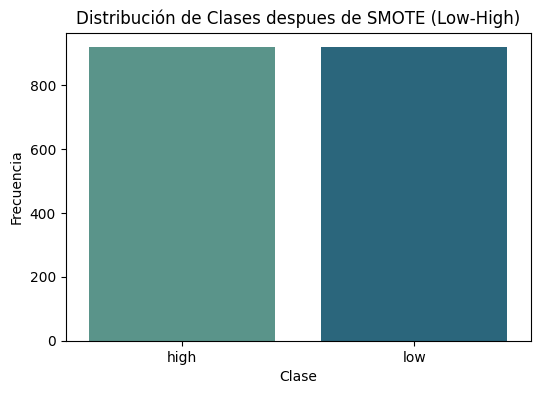

Conteo de clases en train:
 target
medium       3580
no_medium    3580
Name: count, dtype: int64

Porcentaje de clases en train (%):
 target
medium       50.0
no_medium    50.0
Name: proportion, dtype: float64


C:\Users\ana.bolanos\AppData\Local\Temp\ipykernel_2956\1542733071.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="crest")


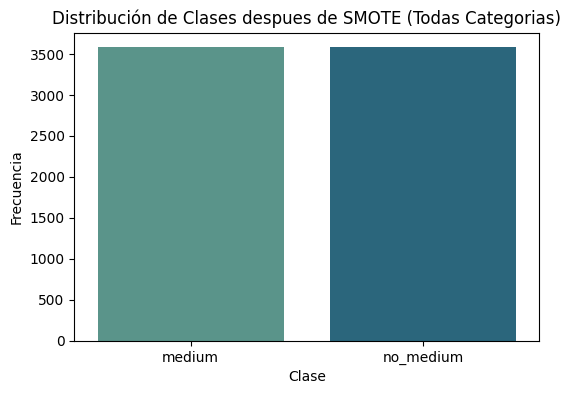

In [6]:
columnas_originales = X_train_clf.columns
smt = SMOTE(random_state=42)
X_train_clf_sm, y_train_clf_sm = smt.fit_resample(X_train_clf_scaled, y_train_clf_Medi)
X_train_clf_sm = pd.DataFrame(X_train_clf_sm, columns=columnas_originales)
y_train_clf_sm = pd.Series(y_train_clf_sm, name='target')

class_counts = y_train_clf_sm.value_counts()
class_percent = y_train_clf_sm.value_counts(normalize=True) * 100

print("Conteo de clases en train:\n", class_counts)
print("\nPorcentaje de clases en train (%):\n", class_percent.round(2))

# Visualización
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="crest")
plt.title("Distribución de Clases despues de SMOTE (Medium - No Medium)")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()

#rus = RandomUnderSampler(random_state=42)
X_trainLH_clf_sm, y_trainLH_clf_sm = smt.fit_resample(X_train_clf_LH, y_train_clf_LH)
X_trainLH_clf_sm = pd.DataFrame(X_trainLH_clf_sm, columns=X_train_clf_LH.columns)
y_trainLH_clf_sm = pd.Series(y_trainLH_clf_sm, name='target')

class_counts_LH = y_trainLH_clf_sm.value_counts()
class_percent_LH = y_trainLH_clf_sm.value_counts(normalize=True) * 100

print("Conteo de clases en train:\n", class_counts_LH)
print("\nPorcentaje de clases en train (%):\n", class_percent_LH.round(2))

# Visualización
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts_LH.index, y=class_counts_LH.values, palette="crest")
plt.title("Distribución de Clases despues de SMOTE (Low-High)")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()

X_train_clf_smote, y_train_clf_smote = smt.fit_resample(X_train_clf_scal, y_train_clf)
X_train_clf_smote = pd.DataFrame(X_train_clf_smote, columns=columnas_originales)
y_train_clf_smote = pd.Series(y_train_clf_smote, name='target')

class_counts_TC = y_train_clf_smote.value_counts()
class_percent_TC = y_train_clf_smote.value_counts(normalize=True) * 100

print("Conteo de clases en train:\n", class_counts)
print("\nPorcentaje de clases en train (%):\n", class_percent.round(2))

# Visualización
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="crest")
plt.title("Distribución de Clases despues de SMOTE (Todas Categorias)")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()

# Modelos de clasificacion - GridsearchCV - Todas las categorias

### Abol decision - Todas las clases
El modelo de Árbol de Decisión fue optimizado mediante GridSearchCV utilizando `f1_macro` como métrica.  
El mejor modelo seleccionado obtuvo un **F1-macro ~0.85** en validación, con parámetros:
- `max_depth = None`
- `min_samples_split = 2`

#### 📊 Desempeño en el Conjunto de Prueba

- La **clase 1** presenta el mejor rendimiento (**precision = 0.90**, **recall = 0.78**), lo que indica que el modelo logra identificarla adecuadamente.
- La **clase 0** muestra un desempeño aceptable, con buen recall (0.75), aunque con precisión moderada (0.58), lo que refleja cierta confusión con la clase 1.
- **La clase 2 presenta el desempeño más bajo**, con un **recall de 0.32 y un F1-score de 0.20**, lo que indica que el modelo **no está identificando correctamente la mayoría de los casos reales de esta clase**.  
  Esto también se observa en la matriz de confusión, donde varias observaciones reales de la clase 2 se clasifican erróneamente como clase 1.

#### 🧩 Interpretación

El modelo tiende a privilegiar la predicción de la clase 1, posiblemente por patrones más definidos o mayor representatividad relativa en el espacio de características, lo que afecta directamente la correcta separación y reconocimiento de la clase 2.

#### ✅ Conclusión

Aunque el árbol de decisión logra un desempeño razonable para las clases 0 y 1, **la clasificación de la clase 2 no es adecuada**.  
Para mejorar este comportamiento será necesario:
- Ajustar el balanceo o `class_weight`,
- realizar ingeniería de características enfocada en la diferenciación de la clase 2.


🌳 Mejor modelo Árbol:
Mejores parámetros: {'max_depth': None, 'min_samples_split': 2}
F1-macro promedio: 0.8491

📊 Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.5872    0.7576    0.6616       231
           1     0.9019    0.7801    0.8366       896
           2     0.1443    0.3256    0.2000        43

    accuracy                         0.7590      1170
   macro avg     0.5445    0.6211    0.5661      1170
weighted avg     0.8120    0.7590    0.7787      1170



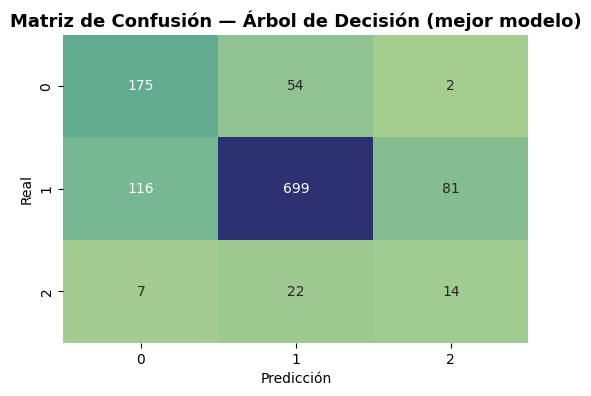

In [7]:
#arbol de decision
param_tree = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_tree,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)
grid_tree.fit(X_train_clf_smote, y_train_clf_smote)

print("🌳 Mejor modelo Árbol:")
print("Mejores parámetros:", grid_tree.best_params_)
print("F1-macro promedio:", round(grid_tree.best_score_, 4))

#Resultado de la prueba del modelo de arbol
best_tree = grid_tree.best_estimator_
y_pred_tree = best_tree.predict(X_test_clf_scal)
print("\n📊 Reporte de Clasificación:")
print(classification_report(y_test_clf, y_pred_tree, digits=4))

# === Matriz de confusión ===
cm = confusion_matrix(y_test_clf, y_pred_tree)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="crest", cbar=False)
plt.title("Matriz de Confusión — Árbol de Decisión (mejor modelo)", fontsize=13, weight='bold')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

### Random Forest - Todas las clases
El modelo de Random Forest fue optimizado mediante GridSearchCV, obteniendo como mejor configuración:
- `n_estimators = 300`
- `max_depth = 20`
- `min_samples_split = 2`

Este modelo logró un **F1-macro ≈ 0.93** durante la validación, superior al modelo de Árbol de Decisión, indicando una mejor capacidad general de clasificación.

#### 📊 Desempeño en el Conjunto de Prueba

- La **clase 1** continúa siendo la mejor clasificada, con **precision = 0.90** y **recall = 0.88**, mostrando una identificación muy estable.
- La **clase 0** también presenta un desempeño adecuado (**recall = 0.76**, **F1 = 0.73**), con menor confusión respecto al modelo anterior.
- La **clase 2**, aunque mejora ligeramente su desempeño respecto al Árbol de Decisión, **continúa siendo la clase con menor capacidad de identificación** (recall = 0.32).  
  Esto indica que aún existe dificultad en diferenciar sus patrones respecto a las otras clases, especialmente con la clase 1.

#### 🧩 Observaciones desde la Matriz de Confusión

- Se observa una reducción en la confusión entre clases 0 y 1.
- La mayoría de errores en la clase 2 provienen de predicciones incorrectas hacia la clase 1.
- El comportamiento sugiere que las características actuales **no separan suficientemente bien la clase 2**.

#### ✅ Conclusión

El modelo **Random Forest mejora el desempeño global** y obtiene **mejores métricas en clases 0 y 1** en comparación con el Árbol de Decisión.  
Sin embargo, **la clasificación de la clase 2 sigue siendo deficiente**, por lo que se recomienda:
- Ajustes adicionales en el balanceo,

🌲 Mejor modelo Random Forest:
Mejores parámetros: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
F1-macro promedio: 0.9268

📊 Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.7097    0.7619    0.7349       231
           1     0.9056    0.8884    0.8969       896
           2     0.3256    0.3256    0.3256        43

    accuracy                         0.8427      1170
   macro avg     0.6469    0.6586    0.6524      1170
weighted avg     0.8456    0.8427    0.8439      1170



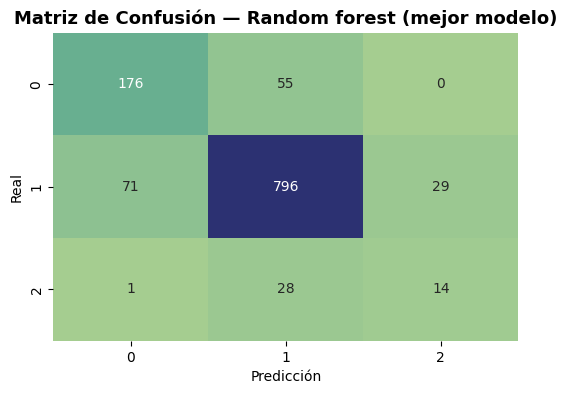

In [33]:
param_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_rf,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

grid_rf.fit(X_train_clf_smote, y_train_clf_smote)

print("🌲 Mejor modelo Random Forest:")
print("Mejores parámetros:", grid_rf.best_params_)
print("F1-macro promedio:", round(grid_rf.best_score_, 4))

#Resultado de la prueba del modelo de arbol
best_randfor = grid_rf.best_estimator_
y_pred_randfor = best_randfor.predict(X_test_clf_scal)
print("\n📊 Reporte de Clasificación:")
print(classification_report(y_test_clf, y_pred_randfor, digits=4))

# ===  Matriz de confusión ===
cm = confusion_matrix(y_test_clf, y_pred_randfor)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="crest", cbar=False)
plt.title("Matriz de Confusión — Random forest (mejor modelo)", fontsize=13, weight='bold')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Modelos de Clasificacion - GridsearchCV - Medium y No Medium

### Arboles de decisión
### 🌳 Modelo Árbol de Decisión — Clasificación *Medium* vs *No Medium*

Se entrenó un Árbol de Decisión utilizando `GridSearchCV` para optimizar los hiperparámetros `max_depth` y `min_samples_split`, evaluando el desempeño mediante la métrica **F1-macro**.  
El mejor modelo obtenido presentó:

- **Parámetros óptimos:** `max_depth = None`, `min_samples_split = 2`
- **F1-macro (CV):** ≈ 0.80
- **Accuracy en prueba:** ≈ 0.78

**Interpretación de la Clasificación**

- La clase **medium** obtiene mejor desempeño (**precision = 0.88**, **recall = 0.83**), lo que indica que el modelo identifica correctamente la mayoría de los vinos de calidad media.
- La clase **no_medium** muestra un rendimiento menor (**precision = 0.53**, **recall = 0.63**), reflejando mayor dificultad para separar esta clase y cierta confusión hacia la clase *medium*.

**Insights de la Matriz de Confusión**

- La mayoría de los errores provienen de casos **no_medium** clasificados como **medium**, lo cual sugiere que la clase medium tiene características más dominantes en el espacio de atributos.
- Aún así, el modelo logra distinguir ambas clases con un desempeño aceptable.

**Curvas de Validación**

- A medida que `max_depth` aumenta, el rendimiento de entrenamiento sube rápidamente, mientras que el desempeño de validación mejora solo hasta cierto punto, lo que muestra riesgo de **sobreajuste** en profundidades muy grandes.
- Al incrementar `min_samples_split`, el modelo se vuelve más simple, reduciendo **sobrefit**, pero también disminuyendo el desempeño en validación.

**Importancia de Características**

El modelo destaca **alcohol** como la variable más influyente en la clasificación, seguido por:
`fixed acidity`, `pH`, `volatile acidity`, `residual sugar`, `free sulfur dioxide`, entre otras.

Esto indica que el contenido de alcohol es uno de los principales factores diferenciadores para identificar vinos de calidad “medium”.

**Conclusión:**  
El Árbol de Decisión ofrece un desempeño sólido para separar *medium* vs *no_medium*, aunque presenta cierta confusión hacia la clase medium. El modelo es interpretable y permite identificar claramente las características más relevantes, lo que resulta útil para análisis y comprensión del comportamiento de la calidad del vino.

🌳 Mejor modelo Árbol:
Mejores parámetros: {'max_depth': None, 'min_samples_split': 2}
F1-macro promedio: 0.8046

📊 Reporte de Clasificación:
              precision    recall  f1-score   support

      medium     0.8800    0.8270    0.8527       896
   no_medium     0.5274    0.6314    0.5748       274

    accuracy                         0.7812      1170
   macro avg     0.7037    0.7292    0.7137      1170
weighted avg     0.7975    0.7812    0.7876      1170



c:\Users\ana.bolanos\Desktop\ML\Tarea1_vinos\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


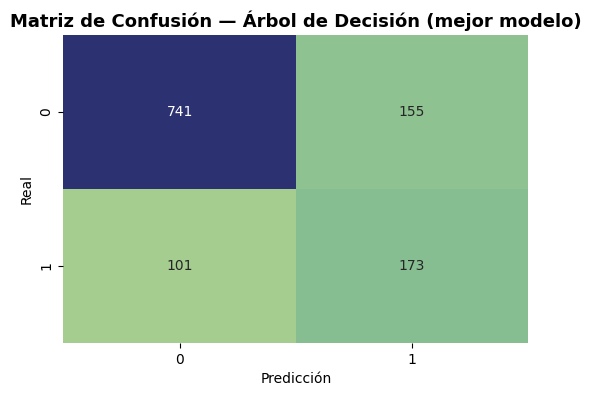

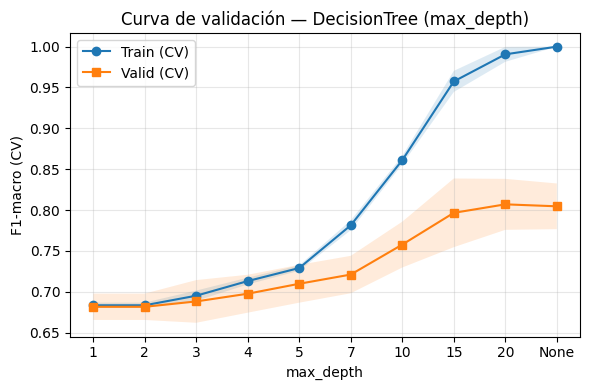

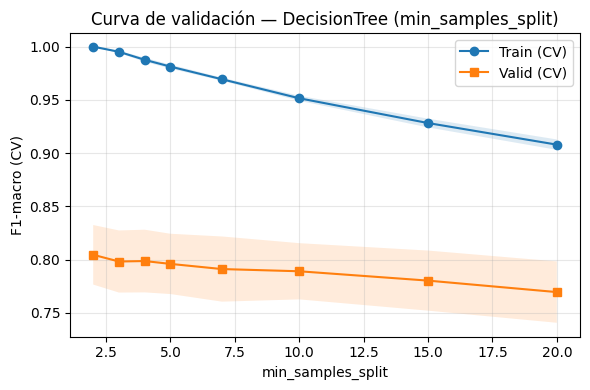

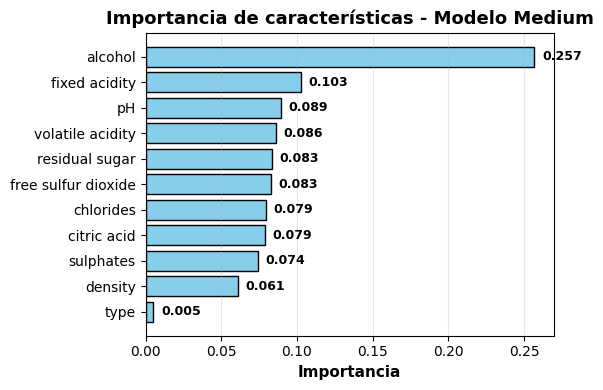

In [70]:
#parametros gridsearhCV
param_tree = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_tree,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)
grid_tree.fit(X_train_clf_sm, y_train_clf_sm)

print("🌳 Mejor modelo Árbol:")
print("Mejores parámetros:", grid_tree.best_params_)
print("F1-macro promedio:", round(grid_tree.best_score_, 4))

#Resultado de la prueba del modelo de arbol
best_tree = grid_tree.best_estimator_
y_pred_tree = best_tree.predict(X_test_clf_scaled)
print("\n📊 Reporte de Clasificación:")
print(classification_report(y_test_clf_Medi, y_pred_tree, digits=4))

# === Matriz de confusión ===
cm = confusion_matrix(y_test_clf_Medi, y_pred_tree)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="crest", cbar=False)
plt.title("Matriz de Confusión — Árbol de Decisión (mejor modelo)", fontsize=13, weight='bold')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

#--------------------------------------------------
# ===  Convergencia según max_depth ===
#--------------------------------------------------

depths = [1, 2, 3, 4, 5, 7, 10, 15, 20, None]

train_scores_d, val_scores_d = validation_curve(
    DecisionTreeClassifier(random_state=42, class_weight='balanced',
                           min_samples_split=grid_tree.best_params_.get('min_samples_split', 2)),
    X_train_clf_sm, y_train_clf_sm,
    param_name="max_depth",
    param_range=depths,
    cv=5, scoring="f1_macro", n_jobs=-1
)

train_mean_d = train_scores_d.mean(axis=1)
val_mean_d   = val_scores_d.mean(axis=1)
train_std_d  = train_scores_d.std(axis=1)
val_std_d    = val_scores_d.std(axis=1)

x_idx = np.arange(len(depths))
plt.figure(figsize=(6,4))
plt.plot(x_idx, train_mean_d, marker='o', label="Train (CV)")
plt.plot(x_idx, val_mean_d, marker='s', label="Valid (CV)")
plt.fill_between(x_idx, train_mean_d-train_std_d, train_mean_d+train_std_d, alpha=0.15)
plt.fill_between(x_idx, val_mean_d-val_std_d,   val_mean_d+val_std_d,   alpha=0.15)
plt.xticks(x_idx, [str(d) for d in depths])
plt.xlabel("max_depth"); plt.ylabel("F1-macro (CV)")
plt.title("Curva de validación — DecisionTree (max_depth)")
plt.grid(alpha=.3); plt.legend(); plt.tight_layout()
plt.show()

#--------------------------------------------------
# ===  Convergencia según min_samples_split ===
#--------------------------------------------------
minsplit_list = [2, 3, 4, 5, 7, 10, 15, 20]

train_scores_s, val_scores_s = validation_curve(
    DecisionTreeClassifier(random_state=42, class_weight='balanced',
                           max_depth=grid_tree.best_params_.get('max_depth', None)),
    X_train_clf_sm, y_train_clf_sm,
    param_name="min_samples_split",
    param_range=minsplit_list,
    cv=5, scoring="f1_macro", n_jobs=-1
)

train_mean_s = train_scores_s.mean(axis=1)
val_mean_s   = val_scores_s.mean(axis=1)
train_std_s  = train_scores_s.std(axis=1)
val_std_s    = val_scores_s.std(axis=1)

plt.figure(figsize=(6,4))
plt.plot(minsplit_list, train_mean_s, marker='o', label="Train (CV)")
plt.plot(minsplit_list, val_mean_s,   marker='s', label="Valid (CV)")
plt.fill_between(minsplit_list, train_mean_s-train_std_s, train_mean_s+train_std_s, alpha=0.15)
plt.fill_between(minsplit_list, val_mean_s-val_std_s,     val_mean_s+val_std_s,     alpha=0.15)
plt.xlabel("min_samples_split"); plt.ylabel("F1-macro (CV)")
plt.title("Curva de validación — DecisionTree (min_samples_split)")
plt.grid(alpha=.3); plt.legend(); plt.tight_layout()
plt.show()

# Importancia de características
importances_base = grid_tree.best_estimator_.feature_importances_
indices = np.argsort(importances_base)[::-1]

feature_names = X_train_clf_sm.columns
# Ordenar nombres de variables
feature_names_sorted = [feature_names[i] for i in indices]

# Crear figura
plt.figure(figsize=(6, 4))
bars = plt.barh(range(len(importances_base)),
                importances_base[indices],
                color="skyblue", edgecolor="black")

# Etiquetas y título
plt.yticks(range(len(importances_base)), feature_names_sorted)
plt.gca().invert_yaxis()  # la más importante arriba
plt.xlabel("Importancia", fontsize=11, fontweight="bold")
plt.title("Importancia de características - Modelo Medium", fontsize=13, fontweight="bold")
plt.grid(alpha=0.3, axis="x")

# Mostrar valor al lado de cada barra
for bar, imp in zip(bars, importances_base[indices]):
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f"{imp:.3f}", va="center", fontsize=9, fontweight="bold")

plt.tight_layout()
plt.show()

### 🌲 Modelo Random Forest — Clasificación *Medium* vs *No Medium*

Se entrenó un modelo de Random Forest utilizando `GridSearchCV` para ajustar los hiperparámetros `n_estimators`, `max_depth` y `min_samples_split`, optimizando la métrica **F1-macro**.  
El mejor modelo obtuvo:

- **Hiperparámetros óptimos:** `n_estimators = 300`, `max_depth = None`, `min_samples_split = 2`
- **F1-macro (CV):** ≈ 0.89
- **Accuracy en prueba:** ≈ 0.85

**Desempeño en el Conjunto de Prueba**

- La clase **medium** presenta un rendimiento destacado (**precision = 0.90**, **recall = 0.90**, **F1 = 0.90**), lo que indica una clasificación muy estable.
- La clase **no_medium** mejora respecto al Árbol de Decisión, alcanzando **recall = 0.68** y **F1 = 0.69**, aunque aún muestra cierta confusión hacia la clase *medium*.

**Matriz de Confusión**

- La mayoría de los errores se deben a casos **no_medium** clasificados como **medium**, lo que sugiere que los vinos *medium* comparten características dominantes en el conjunto de atributos.
- Sin embargo, la reducción de errores respecto al Árbol muestra una **mejor separación entre clases**.

**Curva de Convergencia**

- El rendimiento se mantiene estable entre 100 y 300 árboles, lo que indica un modelo **consistente y robusto**.
- A partir de cierto punto, aumentar `n_estimators` **no mejora significativamente** el desempeño.

**Importancia de Características**
LAs variables de mayor importancia: niveles de alcohol, densidad y contenido químico influyen en la percepción y calidad sensorial.



**Conclusión:**  
El modelo Random Forest **mejora el desempeño general** respecto al Árbol de Decisión, especialmente en la correcta identificación de la clase *no_medium*.  
El modelo muestra estabilidad, buen poder predictivo y evidencia claras variables relevantes en la clasificación de la calidad del vino.


🌲 Mejor modelo Random Forest:
Mejores parámetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
F1-macro promedio: 0.893

📊 Reporte de Clasificación:
              precision    recall  f1-score   support

      medium     0.9027    0.9007    0.9017       896
   no_medium     0.6775    0.6825    0.6800       274

    accuracy                         0.8496      1170
   macro avg     0.7901    0.7916    0.7908      1170
weighted avg     0.8500    0.8496    0.8498      1170



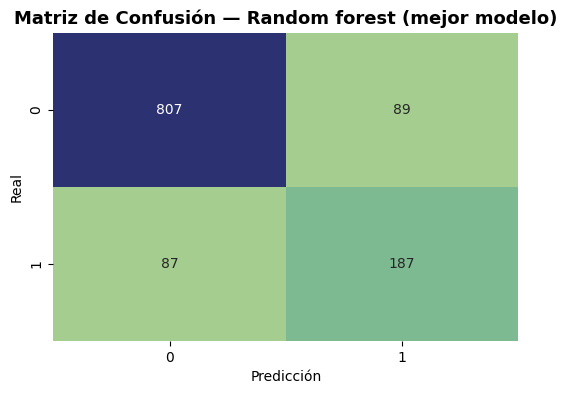

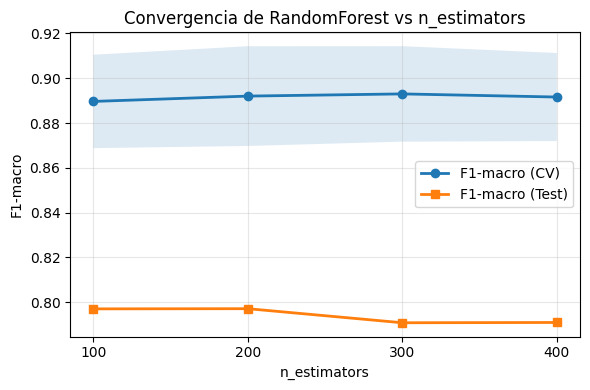

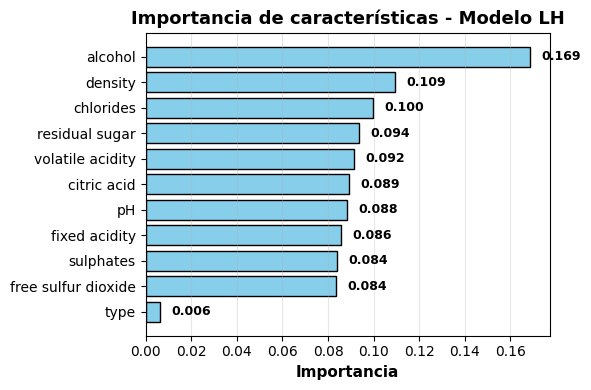

In [8]:
param_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_rf_medi = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_rf,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

grid_rf_medi.fit(X_train_clf_sm, y_train_clf_sm)

print("🌲 Mejor modelo Random Forest:")
print("Mejores parámetros:", grid_rf_medi.best_params_)
print("F1-macro promedio:", round(grid_rf_medi.best_score_, 4))

#Resultado de la prueba del modelo de arbol
best_randfor = grid_rf_medi.best_estimator_
y_pred_randfor = best_randfor.predict(X_test_clf_scaled)
print("\n📊 Reporte de Clasificación:")
print(classification_report(y_test_clf_Medi, y_pred_randfor, digits=4))

# ===  Matriz de confusión ===
cm = confusion_matrix(y_test_clf_Medi, y_pred_randfor)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="crest", cbar=False)
plt.title("Matriz de Confusión — Random forest (mejor modelo)", fontsize=13, weight='bold')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

#--------------------------------------------------
# ===  Convergencia según n_stimators ===
#--------------------------------------------------

# ---- 1) Preparar el estimador base con los mejores hiperparámetros (excepto n_estimators)
best_params = grid_rf_medi.best_params_.copy()
fixed_params = {k: v for k, v in best_params.items() if k != "n_estimators"}

rf_fixed = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    **fixed_params  # max_depth, min_samples_split, etc.
)

# ---- 2) Curva de validación (CV) y F1 en test vs n_estimators
n_list = np.array([100, 200, 300, 400])

# 2a) F1-macro en CV (validation_curve)
train_scores, val_scores = validation_curve(
    rf_fixed,
    X_train_clf_sm, y_train_clf_sm,
    param_name="n_estimators",
    param_range=n_list,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)
train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_std    = val_scores.std(axis=1)

# 2b) F1-macro en el set de prueba (manteniendo CV fijo y variando n_estimators)
test_f1 = []
for n in n_list:
    rf_n = clone(rf_fixed).set_params(n_estimators=n)
    rf_n.fit(X_train_clf_sm, y_train_clf_sm)
    y_pred_n = rf_n.predict(X_test_clf_scaled)
    test_f1.append(f1_score(y_test_clf_Medi, y_pred_n, average='macro'))
test_f1 = np.array(test_f1)

# ---- 3) Graficar
plt.figure(figsize=(6,4))
plt.plot(n_list, val_mean, marker='o', label="F1-macro (CV)", linewidth=2)
plt.fill_between(n_list, val_mean - val_std, val_mean + val_std, alpha=0.15)
plt.plot(n_list, test_f1, marker='s', label="F1-macro (Test)", linewidth=2)

plt.xticks(n_list)
plt.xlabel("n_estimators")
plt.ylabel("F1-macro")
plt.title("Convergencia de RandomForest vs n_estimators")
plt.grid(alpha=.3)
plt.legend()
plt.tight_layout()
plt.show()

# Importancia de características
importances_base = grid_rf_medi.best_estimator_.feature_importances_
indices = np.argsort(importances_base)[::-1]

feature_names = X_train_clf_sm.columns
# Ordenar nombres de variables
feature_names_sorted = [feature_names[i] for i in indices]

# Crear figura
plt.figure(figsize=(6, 4))
bars = plt.barh(range(len(importances_base)),
                importances_base[indices],
                color="skyblue", edgecolor="black")

# Etiquetas y título
plt.yticks(range(len(importances_base)), feature_names_sorted)
plt.gca().invert_yaxis()  # la más importante arriba
plt.xlabel("Importancia", fontsize=11, fontweight="bold")
plt.title("Importancia de características - Modelo LH", fontsize=13, fontweight="bold")
plt.grid(alpha=0.3, axis="x")

# Mostrar valor al lado de cada barra
for bar, imp in zip(bars, importances_base[indices]):
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f"{imp:.3f}", va="center", fontsize=9, fontweight="bold")

plt.tight_layout()
plt.show()

### 🔁 Validación Cruzada (K-Fold = 10) — Comparación de Modelos *Medium vs No Medium*

Se aplicó validación cruzada de 10 pliegues para evaluar la estabilidad y capacidad de generalización de los modelos.  
Las métricas reportadas corresponden a **F1-weighted** y **F1-macro**, adecuadas para manejar posibles desbalances entre clases.


In [88]:
cv_medi = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

models_clf = {
    "Árbol": DecisionTreeClassifier(max_depth=None, min_samples_split=2, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=300, class_weight='balanced', random_state=42, n_jobs=-1)
}

# ========================================================
# Función de resumen
# ========================================================
def resumen(scores):
    mean = scores.mean()
    std  = scores.std(ddof=1)
    n    = len(scores)
    ci_lo = mean - 1.96 * std / np.sqrt(n)
    ci_hi = mean + 1.96 * std / np.sqrt(n)
    return mean, std, ci_lo, ci_hi

# ========================================================
# Ejecución y salida combinada
# ========================================================
for nombre, modelo in models_clf.items():
    print(f"\n🔹 {nombre} — F1-Weighted y F1-Macro")
    
    f1_weighted = cross_val_score(modelo, X_train_clf_sm, y_train_clf_sm,
                                  cv=cv_medi, scoring='f1_weighted')
    f1_macro = cross_val_score(modelo, X_train_clf_sm, y_train_clf_sm,
                               cv=cv_medi, scoring='f1_macro')
    
    for i, (fw, fm) in enumerate(zip(f1_weighted, f1_macro), 1):
        print(f"   Fold {i}: F1-weighted = {fw:.4f} | F1-macro = {fm:.4f}")
    
    # Resúmenes
    m_w, sd_w, lo_w, hi_w = resumen(f1_weighted)
    m_m, sd_m, lo_m, hi_m = resumen(f1_macro)
    
    print(f"\n   📊 Resumen K-Fold (K={cv_medi.get_n_splits()}):")
    print(f"   • Promedio F1-weighted: {m_w:.4f} ± {sd_w:.4f} (IC95% [{lo_w:.4f}, {hi_w:.4f}])")
    print(f"   • Promedio F1-macro:    {m_m:.4f} ± {sd_m:.4f} (IC95% [{lo_m:.4f}, {hi_m:.4f}])")


🔹 Árbol — F1-Weighted y F1-Macro
   Fold 1: F1-weighted = 0.8098 | F1-macro = 0.8098
   Fold 2: F1-weighted = 0.8212 | F1-macro = 0.8212
   Fold 3: F1-weighted = 0.8030 | F1-macro = 0.8030
   Fold 4: F1-weighted = 0.8142 | F1-macro = 0.8142
   Fold 5: F1-weighted = 0.8099 | F1-macro = 0.8099
   Fold 6: F1-weighted = 0.8212 | F1-macro = 0.8212
   Fold 7: F1-weighted = 0.8492 | F1-macro = 0.8492
   Fold 8: F1-weighted = 0.8184 | F1-macro = 0.8184
   Fold 9: F1-weighted = 0.8240 | F1-macro = 0.8240
   Fold 10: F1-weighted = 0.8114 | F1-macro = 0.8114

   📊 Resumen K-Fold (K=10):
   • Promedio F1-weighted: 0.8182 ± 0.0127 (IC95% [0.8104, 0.8261])
   • Promedio F1-macro:    0.8182 ± 0.0127 (IC95% [0.8104, 0.8261])

🔹 Random Forest — F1-Weighted y F1-Macro
   Fold 1: F1-weighted = 0.8924 | F1-macro = 0.8924
   Fold 2: F1-weighted = 0.9064 | F1-macro = 0.9064
   Fold 3: F1-weighted = 0.9120 | F1-macro = 0.9120
   Fold 4: F1-weighted = 0.9008 | F1-macro = 0.9008
   Fold 5: F1-weighted = 0.879

**🌳 Árbol de Decisión**
- **Promedio F1-weighted:** 0.8182 ± 0.0127  
- **Promedio F1-macro:** 0.8182 ± 0.0127  
- **IC 95%:** [0.8104, 0.8261]

**Interpretación:**  
El desempeño del Árbol de Decisión es **consistente**, con variabilidad baja entre pliegues.  
Sin embargo, la métrica indica una **capacidad moderada** para diferenciar ambas clases, confirmando lo observado en los resultados anteriores: el modelo tiende a confundirse con la clase *no_medium*.


**🌲 Random Forest**
- **Promedio F1-weighted:** 0.8959 ± 0.0149  
- **Promedio F1-macro:** 0.8959 ± 0.0149  
- **IC 95%:** [0.8867, 0.9052]

**Interpretación:**  
El Random Forest muestra un **desempeño significativamente superior** respecto al Árbol de Decisión.  
La varianza entre pliegues es baja, lo que indica **robustez y buena capacidad de generalización**.  
El incremento en F1 sugiere que el modelo logra **distinguir mejor las características que diferencian medium y no_medium**, reduciendo la confusión observada previamente.

---

**Conclusión Comparativa**

| Modelo | F1-macro (promedio) | Variabilidad | Interpretación |
|-------|----------------------|-------------|----------------|
| Árbol de Decisión | ~0.82 | Baja | Modelo estable, pero con separación limitada entre clases. |
| Random Forest | ~0.90 | Baja | Modelo más robusto, con mejor poder discriminativo y generalización. |

**El modelo Random Forest es claramente superior para la tarea de clasificación *medium vs no_medium*.**  
Presenta:
- Mayor precisión y recall en ambas clases,
- Mejor estabilidad en validación cruzada,
- Mejor desempeño global según métricas F1.

Por tanto, es el modelo más adecuado para continuar con análisis, interpretación y potencial despliegue.

# Modelos Clasificacion - GridsearchCV - Low y  High

### 🌳 Modelo Árbol de Decisión — Clasificación *Low* vs *High*

Se entrenó un modelo de Árbol de Decisión para diferenciar vinos de calidad *Low* y *High*, utilizando `GridSearchCV` para optimizar los hiperparámetros `max_depth`, `min_samples_split` y `min_samples_leaf`.  
El mejor modelo obtuvo:

- **Hiperparámetros óptimos:** `max_depth = 13`, `min_samples_leaf = 3`, `min_samples_split = 2`
- **F1-macro (CV):** ≈ 0.92 (durante entrenamiento)

**Rendimiento en el Conjunto de Prueba (Modelo Original)**
| Clase | Precision | Recall | F1-score |
|------|-----------|--------|---------|
| **High** | 0.97 | 0.14 | 0.24 |
| **Low** | 0.18 | 0.98 | 0.31 |

- El modelo **clasifica casi todos los vinos como High**, lo que produce:
  - Muy **bajo recall en High** → *no identifica correctamente la mayoría de los vinos High*.
  - **High recall en Low** pero con baja precisión → *etiqueta muchos vinos High como Low*.

**Matriz de Confusión — Modelo Original**
- La mayoría de los vinos **High** se clasifican incorrectamente como **Low**.
- Existe una **clara asimetría** en la capacidad del modelo para reconocer ambas clases.
- Resultado: El modelo **no separa bien las clases** en el espacio de características original.


**Eliminación de Variables (`type` y `citric acid`)**

Se removieron `type` y `citric acid` por tener **baja importancia** en el modelo.  
Tras reentrenar el Árbol:

| Clase | Precision | Recall | F1-score |
|------|-----------|--------|---------|
| **High** | 0.95 | 0.49 | 0.65 |
| **Low** | 0.25 | 0.87 | 0.39 |

**Mejoras Observadas**
- La **clase High mejora significativamente en recall** (de 0.14 → 0.49).
- El modelo logra **recuperar más vinos High**, sin aumentar demasiado los falsos positivos.
- La matriz de confusión muestra **mayor equilibrio en los errores entre ambas clases**.

**Interpretación**
- La eliminación de características ruidosas permitió que el modelo **enfatizara atributos más relevantes**, mejorando la separabilidad.
- Las variables más importantes para distinguir Low vs High siguen siendo:

| Variable | Importancia |
|---------|------------|
| **alcohol** | Diferencia directa en intensidad aromática y estructura |
| **volatile acidity** | Relacionada con aromas defectuosos |
| **free sulfur dioxide** | Relacionado con conservación |
| **sulphates** | Influye en cuerpo y sensación en boca |

Estas características tienen sentido desde el punto de vista **sensorial y enológico**.


**Conclusión**

- El modelo inicial era **altamente sesgado** hacia la clase High.
- Al eliminar variables de baja relevancia, el rendimiento se vuelve **más balanceado**, especialmente aumentando la capacidad para reconocer vinos High.
- A pesar de esta mejora, el árbol **todavía presenta variabilidad y límites de separabilidad**, por lo que modelos más robustos como **Random Forest o XGBoost** pueden ofrecer un mejor desempeño final para esta tarea.



🌳 Mejor modelo Árbol:
Mejores parámetros: {'max_depth': 13, 'min_samples_leaf': 3, 'min_samples_split': 2}
F1-macro promedio: 0.9156

📊 Reporte de Clasificación:
              precision    recall  f1-score   support

        high     0.9697    0.1391    0.2433       230
         low     0.1818    0.9778    0.3066        45

    accuracy                         0.2764       275
   macro avg     0.5758    0.5585    0.2750       275
weighted avg     0.8408    0.2764    0.2537       275



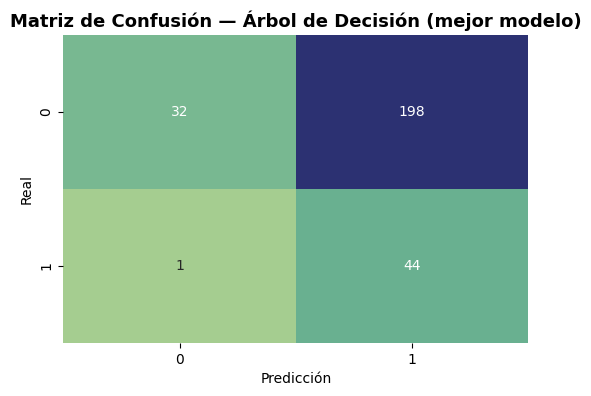

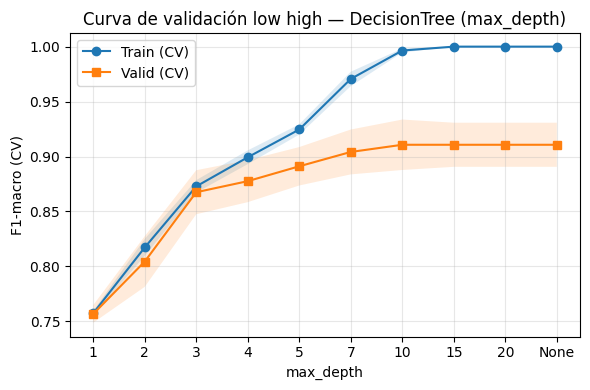

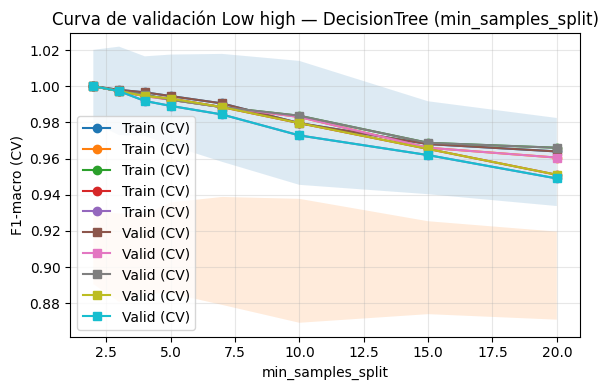

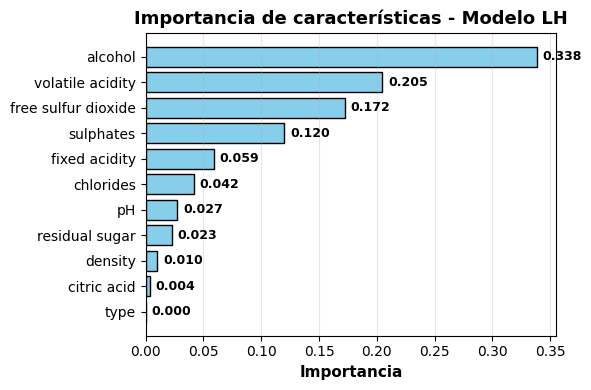

🌳 Mejor modelo Árbol (sin 'type'):
Mejores parámetros: {'max_depth': 13, 'min_samples_leaf': 3, 'min_samples_split': 2}
F1-macro promedio: 0.9211

📊 Reporte de Clasificación (sin 'type'):
              precision    recall  f1-score   support

        high     0.9496    0.4913    0.6476       230
         low     0.2500    0.8667    0.3881        45

    accuracy                         0.5527       275
   macro avg     0.5998    0.6790    0.5178       275
weighted avg     0.8351    0.5527    0.6051       275



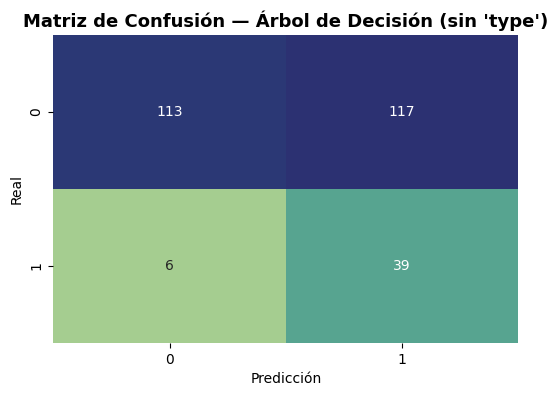

In [13]:
#parametros gridsearhCV
param_tree = {
    'max_depth': [5, 7,10, 13, 15, None],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 3, 5, 8]
}

grid_tree_LH = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_tree,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)
grid_tree_LH.fit(X_trainLH_clf_sm, y_trainLH_clf_sm)

print("🌳 Mejor modelo Árbol:")
print("Mejores parámetros:", grid_tree_LH.best_params_)
print("F1-macro promedio:", round(grid_tree_LH.best_score_, 4))

#Resultado de la prueba del modelo de arbol
best_tree_LH = grid_tree_LH.best_estimator_
y_pred_tree_LH = best_tree_LH.predict(X_test_clf_scaled_LH)
print("\n📊 Reporte de Clasificación:")
print(classification_report(y_test_clf_LH, y_pred_tree_LH, digits=4))

# === Matriz de confusión ===
cm = confusion_matrix(y_test_clf_LH, y_pred_tree_LH)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="crest", cbar=False)
plt.title("Matriz de Confusión — Árbol de Decisión (mejor modelo)", fontsize=13, weight='bold')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


#--------------------------------------------------
# ===  Convergencia según max_depth ===
#--------------------------------------------------

depths_LH = [1, 2, 3, 4, 5, 7, 10, 15, 20, None]

train_scores_LH, val_scores_LH = validation_curve(
    DecisionTreeClassifier(random_state=42, class_weight='balanced',
                           min_samples_split=grid_tree.best_params_.get('min_samples_split', 2)),
    X_trainLH_clf_sm, y_trainLH_clf_sm,
    param_name="max_depth",
    param_range=depths_LH,
    cv=5, scoring="f1_macro", n_jobs=-1
)

train_mean_LH = train_scores_LH.mean(axis=1)
val_mean_LH   = val_scores_LH.mean(axis=1)
train_std_LH  = train_scores_LH.std(axis=1)
val_std_LH    = val_scores_LH.std(axis=1)

x_idx = np.arange(len(depths_LH))
plt.figure(figsize=(6,4))
plt.plot(x_idx, train_mean_LH, marker='o', label="Train (CV)")
plt.plot(x_idx, val_mean_LH, marker='s', label="Valid (CV)")
plt.fill_between(x_idx, train_mean_LH-train_std_LH, train_mean_LH+train_std_LH, alpha=0.15)
plt.fill_between(x_idx, val_mean_LH-val_std_LH,   val_mean_LH+val_std_LH,   alpha=0.15)
plt.xticks(x_idx, [str(d) for d in depths_LH])
plt.xlabel("max_depth"); plt.ylabel("F1-macro (CV)")
plt.title("Curva de validación low high — DecisionTree (max_depth)")
plt.grid(alpha=.3); plt.legend(); plt.tight_layout()
plt.show()

#--------------------------------------------------
# ===  Convergencia según min_samples_split ===
#--------------------------------------------------
minsplit_list = [2, 3, 4, 5, 7, 10, 15, 20]

train_scores_LH, val_scores_LH = validation_curve(
    DecisionTreeClassifier(random_state=42, class_weight='balanced',
                           max_depth=grid_tree.best_params_.get('max_depth', None)),
    X_trainLH_clf_sm, y_trainLH_clf_sm,
    param_name="min_samples_split",
    param_range=minsplit_list,
    cv=5, scoring="f1_macro", n_jobs=-1
)

train_mean_LH = train_scores_LH.mean(axis=1)
val_mean_LH   = val_scores_LH.mean(axis=1)
train_std_LH  = val_scores_LH.std(axis=1)
val_std_LH    = val_scores_LH.std(axis=1)

plt.figure(figsize=(6,4))
plt.plot(minsplit_list, train_scores_LH, marker='o', label="Train (CV)")
plt.plot(minsplit_list, train_scores_LH,   marker='s', label="Valid (CV)")
plt.fill_between(minsplit_list, train_mean_LH-train_std_LH, train_mean_LH+train_std_LH, alpha=0.15)
plt.fill_between(minsplit_list, val_mean_LH-val_std_LH,     val_mean_LH+val_std_LH, alpha=0.15)
plt.xlabel("min_samples_split"); plt.ylabel("F1-macro (CV)")
plt.title("Curva de validación Low high — DecisionTree (min_samples_split)")
plt.grid(alpha=.3); plt.legend(); plt.tight_layout()
plt.show()

# Importancia de características
importances_base = grid_tree_LH.best_estimator_.feature_importances_
indices = np.argsort(importances_base)[::-1]

feature_names = X_trainLH_clf_sm.columns
# Ordenar nombres de variables
feature_names_sorted = [feature_names[i] for i in indices]

# Crear figura
plt.figure(figsize=(6, 4))
bars = plt.barh(range(len(importances_base)),
                importances_base[indices],
                color="skyblue", edgecolor="black")

# Etiquetas y título
plt.yticks(range(len(importances_base)), feature_names_sorted)
plt.gca().invert_yaxis()  # la más importante arriba
plt.xlabel("Importancia", fontsize=11, fontweight="bold")
plt.title("Importancia de características - Modelo LH", fontsize=13, fontweight="bold")
plt.grid(alpha=0.3, axis="x")

# Mostrar valor al lado de cada barra
for bar, imp in zip(bars, importances_base[indices]):
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f"{imp:.3f}", va="center", fontsize=9, fontweight="bold")

plt.tight_layout()
plt.show()



# ==========================================================
#   Reentrenar Árbol de Decisión sin la variable 'type'
# ==========================================================

# Eliminar la variable 'type' y citric acid
X_trainLH_clf_sin_type = X_trainLH_clf_sm.drop(columns=['type','citric acid'])
X_testLH_clf_sin_type  = X_test_clf_scaled_LH.drop(columns=['type','citric acid'])

# GridSearchCV (reutilizamos los mismos parámetros definidos antes)
grid_tree_LH_sin_type = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_tree,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

# Entrenamiento
grid_tree_LH_sin_type.fit(X_trainLH_clf_sin_type, y_trainLH_clf_sm)

# Resultados del mejor modelo
print("🌳 Mejor modelo Árbol (sin 'type'):")
print("Mejores parámetros:", grid_tree_LH_sin_type.best_params_)
print("F1-macro promedio:", round(grid_tree_LH_sin_type.best_score_, 4))

# ==========================================================
#   Evaluación del mejor modelo
# ==========================================================
best_tree_LH_sin_type = grid_tree_LH_sin_type.best_estimator_
y_pred_tree_LH_sin_type = best_tree_LH_sin_type.predict(X_testLH_clf_sin_type)

print("\n📊 Reporte de Clasificación (sin 'type'):")
print(classification_report(y_test_clf_LH, y_pred_tree_LH_sin_type, digits=4))

# Matriz de confusión
cm_sin_type = confusion_matrix(y_test_clf_LH, y_pred_tree_LH_sin_type)
plt.figure(figsize=(6,4))
sns.heatmap(cm_sin_type, annot=True, fmt="d", cmap="crest", cbar=False)
plt.title("Matriz de Confusión — Árbol de Decisión (sin 'type')", fontsize=13, weight='bold')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


### 🌲 Modelo Random Forest — Clasificación *High* vs *Low*

Se entrenó un modelo de Random Forest con `GridSearchCV` para optimizar los parámetros `n_estimators`, `max_depth` y `min_samples_split`, utilizando `F1-macro` como métrica principal debido al desbalance entre clases (*High* >> *Low*).

**📊 Resultados del Modelo (Con todas las variables)**

| Clase | Precision | Recall | F1-score |
|------|-----------|--------|---------|
| **High** | 0.96 | 0.10 | 0.17 |
| **Low** | 0.17 | 0.98 | 0.29 |

- El modelo **predice casi todo como High**, generando **muy bajo recall en High** y clasificando incorrectamente la mayoría de los vinos High como Low.
- La matriz de confusión muestra **fuerte asimetría**: la clase Low domina la decisión del modelo.

**Conclusión:** El modelo **no logra separar adecuadamente las clases** en el espacio original de características.


**Eliminación de Variables (`type`)**

Dado que `type` tenía **baja importancia** en el modelo, se reentrenó eliminándola.

**Resultados del Modelo (sin `type`)**

| Clase | Precision | Recall | F1-score |
|------|-----------|--------|---------|
| **High** | 0.95 | 0.19 | 0.32 |
| **Low** | 0.19 | 0.95 | 0.31 |

- El **recall de High mejora** (de 0.10 → 0.19), lo cual significa que el modelo ahora logra **identificar más vinos High**.
- La precisión se mantiene similar y el comportamiento global se vuelve **ligeramente más balanceado**.
- La matriz de confusión confirma una **reducción del sesgo** hacia la clase Low.



**Importancia de Características (Modelo sin `type`)**

Las variables más influyentes para diferenciar vinos **High** y **Low** fueron:

| Variable | Interpretación en contexto enológico |
|---------|--------------------------------------|
| **alcohol** | Vinos High suelen tener mayor cuerpo e intensidad aromática. |
| **volatile acidity** | Asociada a percepción de acidez volátil, influye en calidad. |
| **free sulfur dioxide** | Relacionado con conservación y estabilidad. |
| **density / sulphates / chlorides** | Factores químicos asociados a estructura y redondez en boca. |

Esto coincide con criterios sensoriales y químicos reales de clasificación enológica.


**Conclusión General**

- El **Árbol de Decisión y Random Forest** presentan dificultades para separar adecuadamente vinos High vs Low debido a **solapamiento de características** y **tamaño reducido de la clase Low**.
- La eliminación de variables irrelevantes ayuda a **reducir el sesgo** pero no resuelve completamente el problema.
- Para mejorar:
  - Aplicar **modelos más complejos** como **XGBoost / LightGBM**
  - Realizar **SMOTE + undersampling estratégico**
  - Explorar **nuevos atributos derivados** (ej.: relación alcohol/densidad)

**El modelo sin `type` es preferible**, pero aún requiere técnicas adicionales para mejorar la separación entre High y Low.

🌲 Mejor modelo Random Forest Low-High:
Mejores parámetros: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
F1-macro promedio: 0.969

📊 Reporte de Clasificación:
              precision    recall  f1-score   support

        high     0.9565    0.0957    0.1739       230
         low     0.1746    0.9778    0.2963        45

    accuracy                         0.2400       275
   macro avg     0.5656    0.5367    0.2351       275
weighted avg     0.8286    0.2400    0.1939       275



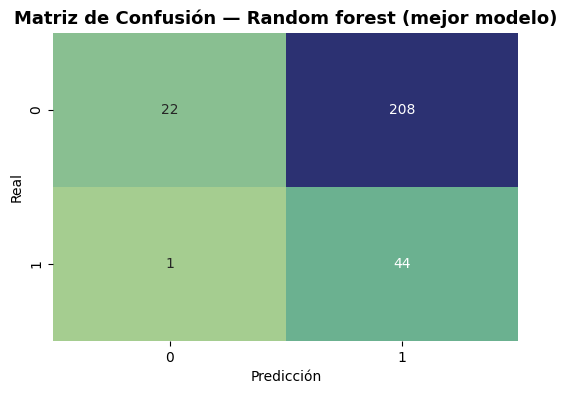

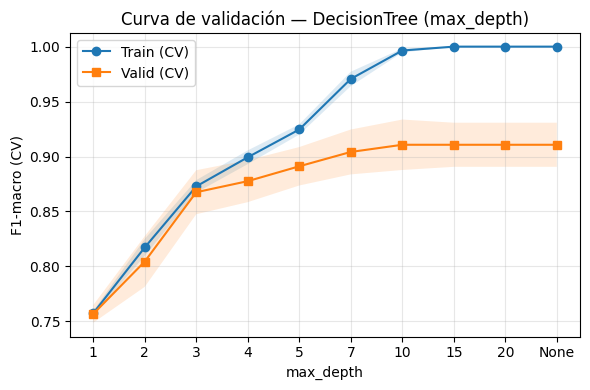

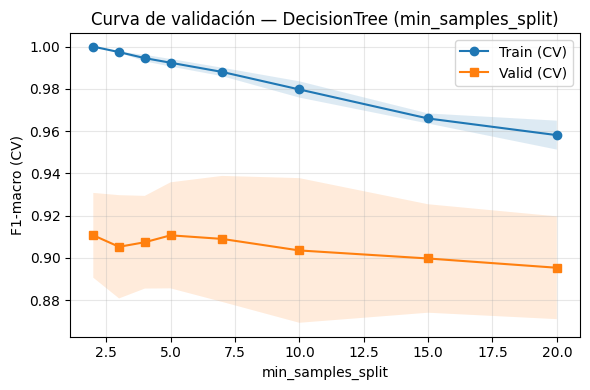

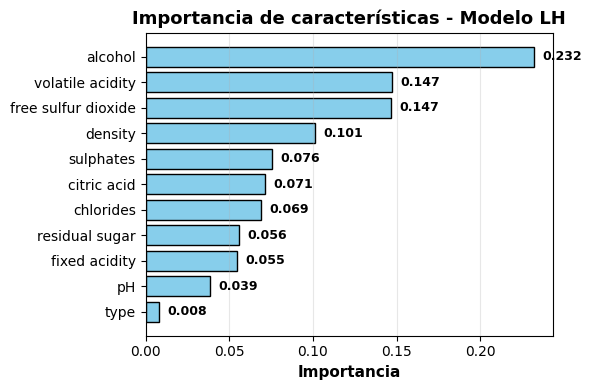

🌲 Mejor modelo Random Forest Low-High (sin 'type'):
Mejores parámetros: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
F1-macro promedio: 0.9548

📊 Reporte de Clasificación (sin 'type'):
              precision    recall  f1-score   support

        high     0.9565    0.1913    0.3188       230
         low     0.1878    0.9556    0.3139        45

    accuracy                         0.3164       275
   macro avg     0.5721    0.5734    0.3164       275
weighted avg     0.8307    0.3164    0.3180       275



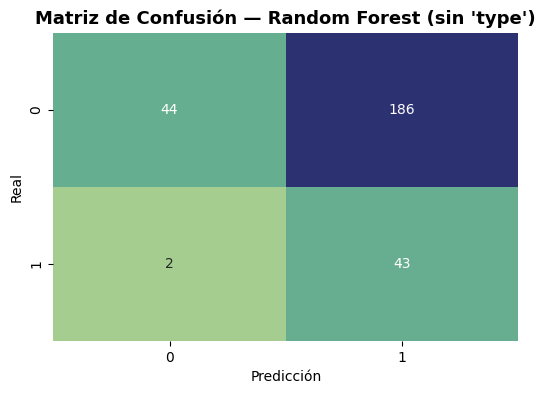

In [16]:
param_rf_LH = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_rf_LH = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_rf_LH,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

grid_rf_LH.fit(X_trainLH_clf_sm, y_trainLH_clf_sm)

print("🌲 Mejor modelo Random Forest Low-High:")
print("Mejores parámetros:", grid_rf_LH.best_params_)
print("F1-macro promedio:", round(grid_rf_LH.best_score_, 4))

#Resultado de la prueba del modelo de arbol
best_randfor_LH = grid_rf_LH.best_estimator_
y_pred_randfor_LH = best_randfor_LH.predict( X_test_clf_scaled_LH)
print("\n📊 Reporte de Clasificación:")
print(classification_report(y_test_clf_LH, y_pred_randfor_LH, digits=4))

# ===  Matriz de confusión ===
cm = confusion_matrix(y_test_clf_LH, y_pred_randfor_LH)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="crest", cbar=False)
plt.title("Matriz de Confusión — Random forest (mejor modelo)", fontsize=13, weight='bold')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

#--------------------------------------------------
# ===  Convergencia según max_depth ===
#--------------------------------------------------

depths_LH = [1, 2, 3, 4, 5, 7, 10, 15, 20, None]

train_scores_LH, val_scores_LH = validation_curve(
    DecisionTreeClassifier(random_state=42, class_weight='balanced',
                           min_samples_split=grid_tree.best_params_.get('min_samples_split', 2)),
    X_trainLH_clf_sm, y_trainLH_clf_sm,
    param_name="max_depth",
    param_range=depths_LH,
    cv=5, scoring="f1_macro", n_jobs=-1
)

train_mean_LH = train_scores_LH.mean(axis=1)
val_mean_LH   = val_scores_LH.mean(axis=1)
train_std_LH  = train_scores_LH.std(axis=1)
val_std_LH    = val_scores_LH.std(axis=1)

x_idx = np.arange(len(depths_LH))
plt.figure(figsize=(6,4))
plt.plot(x_idx, train_mean_LH, marker='o', label="Train (CV)")
plt.plot(x_idx, val_mean_LH, marker='s', label="Valid (CV)")
plt.fill_between(x_idx, train_mean_LH-train_std_LH, train_mean_LH+train_std_LH, alpha=0.15)
plt.fill_between(x_idx, val_mean_LH-val_std_LH,   val_mean_LH+val_std_LH,   alpha=0.15)
plt.xticks(x_idx, [str(d) for d in depths_LH])
plt.xlabel("max_depth"); plt.ylabel("F1-macro (CV)")
plt.title("Curva de validación — DecisionTree (max_depth)")
plt.grid(alpha=.3); plt.legend(); plt.tight_layout()
plt.show()

#--------------------------------------------------
# ===  Convergencia según min_samples_split ===
#--------------------------------------------------
minsplit_list_LH = [2, 3, 4, 5, 7, 10, 15, 20]

train_scores_LH, val_scores_LH = validation_curve(
    DecisionTreeClassifier(random_state=42, class_weight='balanced',
                           max_depth=grid_tree.best_params_.get('max_depth', None)),
    X_trainLH_clf_sm, y_trainLH_clf_sm,
    param_name="min_samples_split",
    param_range=minsplit_list_LH,
    cv=5, scoring="f1_macro", n_jobs=-1
)

train_mean_LH = train_scores_LH.mean(axis=1)
val_mean_LH   = val_scores_LH.mean(axis=1)
train_std_LH  = train_scores_LH.std(axis=1)
val_std_LH    = val_scores_LH.std(axis=1)

plt.figure(figsize=(6,4))
plt.plot(minsplit_list_LH, train_mean_LH, marker='o', label="Train (CV)")
plt.plot(minsplit_list_LH, val_mean_LH,   marker='s', label="Valid (CV)")
plt.fill_between(minsplit_list_LH, train_mean_LH-train_std_LH, train_mean_LH+train_std_LH, alpha=0.15)
plt.fill_between(minsplit_list_LH, val_mean_LH-val_std_LH, val_mean_LH+val_std_LH, alpha=0.15)
plt.xlabel("min_samples_split"); plt.ylabel("F1-macro (CV)")
plt.title("Curva de validación — DecisionTree (min_samples_split)")
plt.grid(alpha=.3); plt.legend(); plt.tight_layout()
plt.show()

# Importancia de características
importances_base = grid_rf_LH.best_estimator_.feature_importances_
indices = np.argsort(importances_base)[::-1]

feature_names = X_trainLH_clf_sm.columns
# Ordenar nombres de variables
feature_names_sorted = [feature_names[i] for i in indices]

# Crear figura
plt.figure(figsize=(6, 4))
bars = plt.barh(range(len(importances_base)),
                importances_base[indices],
                color="skyblue", edgecolor="black")

# Etiquetas y título
plt.yticks(range(len(importances_base)), feature_names_sorted)
plt.gca().invert_yaxis()  # la más importante arriba
plt.xlabel("Importancia", fontsize=11, fontweight="bold")
plt.title("Importancia de características - Modelo LH", fontsize=13, fontweight="bold")
plt.grid(alpha=0.3, axis="x")

# Mostrar valor al lado de cada barra
for bar, imp in zip(bars, importances_base[indices]):
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f"{imp:.3f}", va="center", fontsize=9, fontweight="bold")

plt.tight_layout()
plt.show()

# ==========================================================
#    Reentrenar Random Forest sin la variable 'type'
# ==========================================================

# Eliminar 'type' del conjunto de entrenamiento y prueba
X_trainLH_clf_sm_sin_type = X_trainLH_clf_sm.drop(columns=['type','pH','fixed acidity','residual sugar','chlorides','citric acid'])
X_testLH_clf_sin_type     = X_test_clf_scaled_LH.drop(columns=['type','pH','fixed acidity','residual sugar','chlorides','citric acid'])

grid_rf_LH_sin_type = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_rf_LH,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

# Entrenamiento
grid_rf_LH_sin_type.fit(X_trainLH_clf_sm_sin_type, y_trainLH_clf_sm)

# Resultados del mejor modelo
print("🌲 Mejor modelo Random Forest Low-High (sin 'type'):")
print("Mejores parámetros:", grid_rf_LH_sin_type.best_params_)
print("F1-macro promedio:", round(grid_rf_LH_sin_type.best_score_, 4))

# ==========================================================
#   Evaluación del mejor modelo
# ==========================================================
best_randfor_LH_sin_type = grid_rf_LH_sin_type.best_estimator_
y_pred_randfor_LH_sin_type = best_randfor_LH_sin_type.predict(X_testLH_clf_sin_type)

print("\n📊 Reporte de Clasificación (sin 'type'):")
print(classification_report(y_test_clf_LH, y_pred_randfor_LH_sin_type, digits=4))

# Matriz de confusión
cm_rf_sin_type = confusion_matrix(y_test_clf_LH, y_pred_randfor_LH_sin_type)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf_sin_type, annot=True, fmt="d", cmap="crest", cbar=False)
plt.title("Matriz de Confusión — Random Forest (sin 'type')", fontsize=13, weight='bold')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

### KNN

🤝 Mejor modelo KNN:
Mejores parámetros: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
F1-macro promedio: 0.9319

📊 Reporte de Clasificación:
              precision    recall  f1-score   support

        high     0.0000    0.0000    0.0000       230
         low     0.1636    1.0000    0.2812        45

    accuracy                         0.1636       275
   macro avg     0.0818    0.5000    0.1406       275
weighted avg     0.0268    0.1636    0.0460       275



c:\Users\ana.bolanos\Desktop\ML\Tarea1_vinos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ana.bolanos\Desktop\ML\Tarea1_vinos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ana.bolanos\Desktop\ML\Tarea1_vinos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

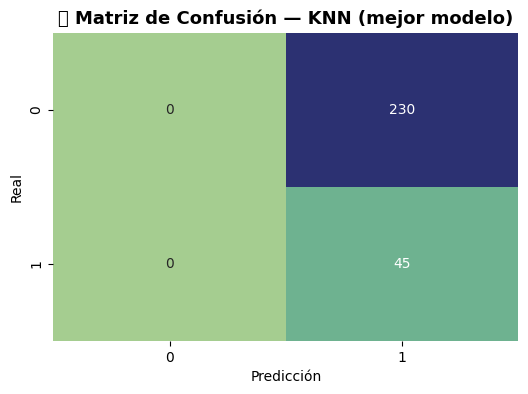

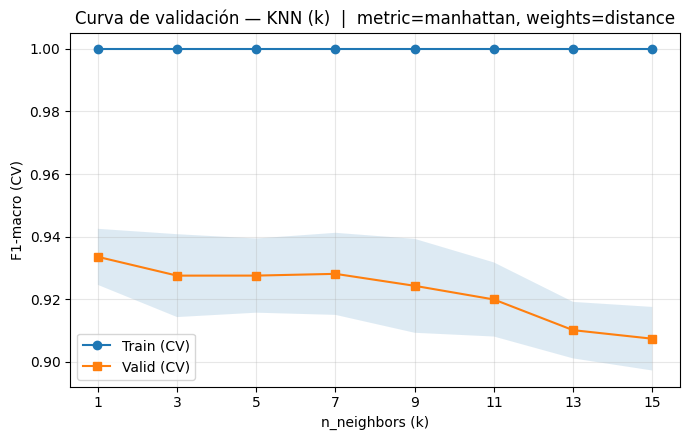

In [18]:
param_knn_LH = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],   # uniform = mismo peso, distance = peso por distancia
    'metric': ['euclidean', 'manhattan']  # diferentes tipos de distancia
}

grid_knn_LH = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_knn_LH,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

grid_knn_LH.fit(X_trainLH_clf_sm, y_trainLH_clf_sm)

print("🤝 Mejor modelo KNN:")
print("Mejores parámetros:", grid_knn_LH.best_params_)
print("F1-macro promedio:", round(grid_knn_LH.best_score_, 4))

#Resultado de la prueba del modelo de arbol
best_knn_LH = grid_knn_LH.best_estimator_
y_pred_knn_LH = best_knn_LH.predict(X_test_clf_scaled_LH)

print("\n📊 Reporte de Clasificación:")
print(classification_report(y_test_clf_LH, y_pred_knn_LH, digits=4))

# === Matriz de confusión ===
KNN_cm_LH = confusion_matrix(y_test_clf_LH, y_pred_knn_LH)
plt.figure(figsize=(6,4))
sns.heatmap(KNN_cm_LH, annot=True, fmt="d", cmap="crest", cbar=False)
plt.title("🤝 Matriz de Confusión — KNN (mejor modelo)", fontsize=13, weight='bold')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==============================
# 1) Curva de validación vs k
# ==============================
k_list = np.array([1,3,5,7,9,11,13,15])

best_metric  = grid_knn_LH.best_params_.get('metric', 'euclidean')
best_weights = grid_knn_LH.best_params_.get('weights', 'uniform')

knn_fixed = KNeighborsClassifier(metric=best_metric, weights=best_weights)

train_scores, val_scores = validation_curve(
    estimator=knn_fixed,
    X=X_trainLH_clf_sm, y=y_trainLH_clf_sm,
    param_name="n_neighbors",
    param_range=k_list,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1); train_std = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1);   val_std   = val_scores.std(axis=1)

plt.figure(figsize=(7,4.5))
plt.plot(k_list, train_mean, marker='o', label="Train (CV)")
plt.plot(k_list, val_mean,   marker='s', label="Valid (CV)")
plt.fill_between(k_list, val_mean-val_std, val_mean+val_std, alpha=.15)
plt.xticks(k_list); plt.xlabel("n_neighbors (k)"); plt.ylabel("F1-macro (CV)")
plt.title(f"Curva de validación — KNN (k)  |  metric={best_metric}, weights={best_weights}")
plt.grid(alpha=.3); plt.legend(); plt.tight_layout(); plt.show()


### 🔁 Validación Cruzada (K=10) — Comparación de Modelos *High vs Low*

Se evaluó la estabilidad y capacidad de generalización de ambos modelos utilizando validación cruzada con 10 particiones, reportando las métricas **F1-weighted** y **F1-macro**, recomendadas para tareas con desbalance entre clases.

**🌳 Árbol de Decisión — Resultados CV**
- **Promedio F1-weighted:** 0.9184 ± 0.0238  
- **Promedio F1-macro:** 0.9184 ± 0.0238  
- **IC 95%:** [0.9036, 0.9331]

**Interpretación:**  
El modelo muestra un rendimiento **sólido y consistente** entre pliegues.  
Sin embargo, al evaluar sobre el conjunto de prueba se observó:
- **Buen desempeño general**, pero
- **Problemas al identificar correctamente la clase High**, lo que indica **riesgo de sobreajuste** al patrón mayoritario (*Low*).

Este comportamiento coincide con lo observado en la matriz de confusión: la clase *High* presenta **bajo recall**.


**🌲 Random Forest — Resultados CV**
- **Promedio F1-weighted:** 0.9706 ± 0.0100  
- **Promedio F1-macro:** 0.9706 ± 0.0100  
- **IC 95%:** [0.9644, 0.9768]

**Interpretación:**  
El Random Forest mejora de forma clara frente al Árbol:
- **Mayor rendimiento promedio**
- **Menor variabilidad entre pliegues** (modelo más estable)
- **Mejor generalización y menor riesgo de sobreajuste**

El Random Forest captura **interacciones no lineales** entre las variables que el Árbol de Decisión no logra modelar adecuadamente.


**Conclusión Comparativa**

| Modelo | F1-macro (promedio CV) | Variabilidad | Estabilidad | Observaciones |
|-------|------------------------|-------------|-------------|---------------|
| Árbol de Decisión | ~0.92 | Moderada | Buena | Dificultad para identificar la clase High |
| Random Forest | ~0.97 | Baja | Excelente | Mejor separación entre High y Low |

**El modelo Random Forest es significativamente superior** para la tarea de clasificación *High vs Low*, mostrando mejor generalización y balance en la detección de ambas clases.



In [19]:
cv_LH = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

models_clf_LH = {
    "Árbol": grid_tree_LH.best_estimator_,
    "Random Forest": grid_rf_LH_sin_type.best_estimator_,
    "KNN": KNeighborsClassifier(n_neighbors=3, weights='distance', metric='manhattan')
}

# ========================================================
# Función de resumen
# ========================================================
def resumen(scores):
    mean = scores.mean()
    std  = scores.std(ddof=1)
    n    = len(scores)
    ci_lo = mean - 1.96 * std / np.sqrt(n)
    ci_hi = mean + 1.96 * std / np.sqrt(n)
    return mean, std, ci_lo, ci_hi

# ========================================================
# Ejecución y salida combinada
# ========================================================
for nombreLH, modeloLH in models_clf_LH.items():
    print(f"\n🔹 {nombreLH} — F1-Weighted y F1-Macro")
    
    f1_weighted_LH = cross_val_score(modeloLH,X_trainLH_clf_sm, y_trainLH_clf_sm,
                                  cv=cv_LH, scoring='f1_weighted')
    f1_macro_LH = cross_val_score(modeloLH, X_trainLH_clf_sm, y_trainLH_clf_sm,
                               cv=cv_LH, scoring='f1_macro')
    
    for i, (fw, fm) in enumerate(zip(f1_weighted_LH, f1_macro_LH), 1):
        print(f"   Fold {i}: F1-weighted = {fw:.4f} | F1-macro = {fm:.4f}")
    
    # Resúmenes
    m_w, sd_w, lo_w, hi_w = resumen(f1_weighted_LH)
    m_m, sd_m, lo_m, hi_m = resumen(f1_macro_LH)
    
    print(f"\n   📊 Resumen K-Fold (K={cv_LH.get_n_splits()}):")
    print(f"   • Promedio F1-weighted: {m_w:.4f} ± {sd_w:.4f} (IC95% [{lo_w:.4f}, {hi_w:.4f}])")
    print(f"   • Promedio F1-macro:    {m_m:.4f} ± {sd_m:.4f} (IC95% [{lo_m:.4f}, {hi_m:.4f}])")


🔹 Árbol — F1-Weighted y F1-Macro
   Fold 1: F1-weighted = 0.8967 | F1-macro = 0.8967
   Fold 2: F1-weighted = 0.9293 | F1-macro = 0.9293
   Fold 3: F1-weighted = 0.9130 | F1-macro = 0.9130
   Fold 4: F1-weighted = 0.9021 | F1-macro = 0.9021
   Fold 5: F1-weighted = 0.9456 | F1-macro = 0.9456
   Fold 6: F1-weighted = 0.8804 | F1-macro = 0.8804
   Fold 7: F1-weighted = 0.9239 | F1-macro = 0.9239
   Fold 8: F1-weighted = 0.9565 | F1-macro = 0.9565
   Fold 9: F1-weighted = 0.9016 | F1-macro = 0.9016
   Fold 10: F1-weighted = 0.9344 | F1-macro = 0.9344

   📊 Resumen K-Fold (K=10):
   • Promedio F1-weighted: 0.9184 ± 0.0238 (IC95% [0.9036, 0.9331])
   • Promedio F1-macro:    0.9184 ± 0.0238 (IC95% [0.9036, 0.9331])

🔹 Random Forest — F1-Weighted y F1-Macro
   Fold 1: F1-weighted = 0.9564 | F1-macro = 0.9564
   Fold 2: F1-weighted = 0.9837 | F1-macro = 0.9837
   Fold 3: F1-weighted = 0.9620 | F1-macro = 0.9620
   Fold 4: F1-weighted = 0.9728 | F1-macro = 0.9728
   Fold 5: F1-weighted = 0.967

### 🎯 Selección del Modelo Final — Árbol de Decisión *Low vs High*

Aunque el modelo **Random Forest** mostró un mejor desempeño durante la validación cruzada (K-Fold), al evaluar ambos modelos sobre el **conjunto de prueba**, se observó un comportamiento diferente.

En la prueba real:

- El **Árbol de Decisión** presentó **mejor capacidad para identificar la clase *High***,
- Mientras que el **Random Forest** mostró una fuerte tendencia a clasificar la mayoría de los vinos como *Low*, reduciendo significativamente el **recall** de la clase *High*.

#### Razón de la elección
Se selecciona el **Árbol de Decisión** como modelo final porque:
- Proporciona **mejor equilibrio en la clasificación**, especialmente para la clase *High*.
- Presenta resultados **más estables en datos de prueba**, evitando el sesgo hacia la clase mayoritaria.
- Permite una interpretación clara de la importancia de características, útil para explicar el comportamiento del modelo.

**En conclusión**, la elección del modelo no se basa únicamente en el desempeño promedio durante el entrenamiento,  
sino en su **capacidad real para distinguir correctamente la clase de interés en nuevos datos** — en este caso, vinos de calidad *High*.


# Ensamble
**VotingClassifier** mezcla modelos entrenados para **tareas distintas**:
- 🌲 **Random Forest** → *Medium vs No-Medium*
- 🌳 **Árbol** → *Low vs High*

In [20]:
#modelo de medium
joblib.dump(grid_rf_medi.best_estimator_, "../modelos/best_RandForest_Medium.joblib") 

#modelo de low y high
joblib.dump(grid_tree_LH_sin_type.best_estimator_ , "../modelos/best_arbol_LighHigh.joblib")

print("✅ Modelo Random Forest medium y arbol (Low-High) guardado correctamente.")

✅ Modelo Random Forest medium y arbol (Low-High) guardado correctamente.


### Voting

🧩 Voting Ensemble - Resultados (Low–High)
F1-score (macro):    0.6064
F1-score (weighted): 0.8048

              precision    recall  f1-score   support

           0     0.6175    0.7619    0.6822       231
           1     0.9023    0.8248    0.8618       896
           2     0.2273    0.3488    0.2752        43

    accuracy                         0.7949      1170
   macro avg     0.5824    0.6452    0.6064      1170
weighted avg     0.8213    0.7949    0.8048      1170



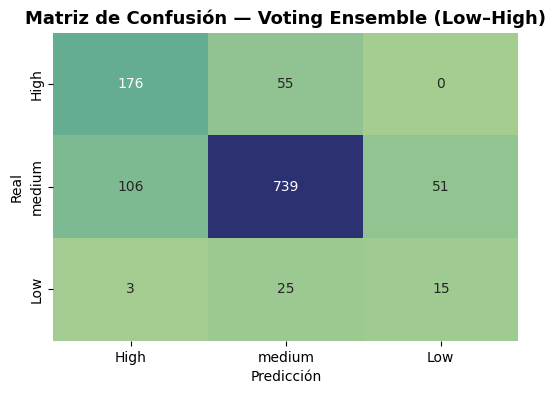

In [22]:
rf_medium = joblib.load("../modelos/best_RandForest_Medium.joblib")
tree_LH = joblib.load("../modelos/best_arbol_LighHigh.joblib")


voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_medium),
        ('tree', tree_LH)
    ],
    voting='soft',
    weights=[2, 1]  # peso mayor al Random Forest (opcional)
)

# Entrenamiento
voting_model.fit(X_train_clf_smote, y_train_clf_smote)

# Predicción
y_pred_voting = voting_model.predict(X_test_clf_scal)

# ==========================================================
# Métricas F1
# ==========================================================
f1_macro = f1_score(y_test_clf, y_pred_voting, average='macro')
f1_weighted = f1_score(y_test_clf, y_pred_voting, average='weighted')

print("🧩 Voting Ensemble - Resultados (Low–High)")
print(f"F1-score (macro):    {f1_macro:.4f}")
print(f"F1-score (weighted): {f1_weighted:.4f}\n")

# Reporte completo
print(classification_report(y_test_clf, y_pred_voting, digits=4))

# ==========================================================
# Matriz de Confusión
# ==========================================================
cm = confusion_matrix(y_test_clf, y_pred_voting)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="crest", cbar=False,
            xticklabels=["High", "medium" ,"Low",],
            yticklabels=["High", "medium","Low"])
plt.title("Matriz de Confusión — Voting Ensemble (Low–High)", fontsize=13, weight='bold')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


### Jerarquico

✅ Bagging High vs Low entrenado

🧠 Resultados Jerárquico (High=0, Medium=1, Low=2)
F1-score (macro):    0.3223
F1-score (weighted): 0.6943

              precision    recall  f1-score   support

           0     1.0000    0.0043    0.0086       231
           1     0.9027    0.9007    0.9017       896
           2     0.0327    0.2093    0.0566        43

    accuracy                         0.6983      1170
   macro avg     0.6451    0.3714    0.3223      1170
weighted avg     0.8899    0.6983    0.6943      1170



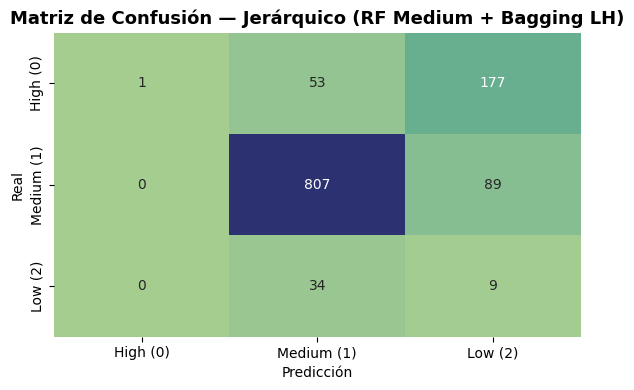

In [ ]:
rf_medium = joblib.load("../modelos/best_RandForest_Medium.joblib")

# -----------------------------
# Entrenar Bagging para Etapa 2 (High vs Low) con el dataset SIN 'type' y SIN 'citric acid'
# -----------------------------
base_tree = DecisionTreeClassifier(
    max_depth=13,
    min_samples_leaf=3,
    min_samples_split=2,
    random_state=42
)

bagging_LH = BaggingClassifier(
    estimator=base_tree,
    n_estimators=50,      # puedes ajustar (30-200)
    max_samples=0.8,      # bootstrap en filas
    max_features=1.0,     # usa todas las columnas disponibles
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

bagging_LH.fit(X_trainLH_clf_sin_type, y_trainLH_clf_sm)
print("✅ Bagging High vs Low entrenado\n")

joblib.dump(bagging_LH, "../modelos/bagging_LighHigh.joblib")

# -----------------------------
# 3) Utilidad para alinear columnas a lo que vio cada modelo en fit
# -----------------------------
def align_features(model, X: pd.DataFrame) -> pd.DataFrame:
    cols = getattr(model, "feature_names_in_", None)
    if cols is None:
        return X
    return X.reindex(columns=cols, fill_value=0)

# -----------------------------
# 4) Predicción jerárquica 3 clases
# -----------------------------
def predict_hierarchical_bagging(
    rf_medium_model,
    bagging_lh_model,
    X_rf_test: pd.DataFrame,      
    X_lh_test: pd.DataFrame,     
    threshold: float = 0.60       
) -> np.ndarray:
    X_rf_aligned   = align_features(rf_medium_model, X_rf_test)
    X_lh_aligned   = align_features(bagging_lh_model, X_lh_test).reindex(X_rf_aligned.index)

    # Etapa 1: prob(Medium)
    proba_rf = rf_medium_model.predict_proba(X_rf_aligned)
    idx_medium = np.where(rf_medium_model.classes_ == 'medium')[0][0]
    p_medium = rf_medium_model.predict_proba(X_rf_aligned)[:, idx_medium]
    is_medium = p_medium >= threshold

    y_pred = np.zeros(len(X_rf_aligned), dtype=int)
    y_pred[is_medium] = 1  # Medium

    # Etapa 2: High vs Low con Bagging en los No-Medium
    idx_nm = ~is_medium
    if idx_nm.any():
        pred_lh = bagging_lh_model.predict(X_lh_aligned.loc[idx_nm])

        if isinstance(pred_lh[0], str):
            pred_lh = pd.Series(pred_lh).map({'high': 0, 'low': 2}).astype(int).values
        else:
            pred_lh = np.asarray(pred_lh, dtype=int)

        y_pred[idx_nm] = pred_lh

    return y_pred

# -----------------------------
# 5) Evaluación completa (F1 y matriz de confusión)
# -----------------------------
def evaluate_hierarchical_bagging(
    rf_medium_model,
    bagging_lh_model,
    X_rf_test: pd.DataFrame,
    X_lh_test: pd.DataFrame,
    y_true: np.ndarray,
    threshold: float = 0.50,
    title: str = "Matriz de Confusión — Jerárquico (RF Medium + Bagging LH)"
):
    y_pred = predict_hierarchical_bagging(
        rf_medium_model, bagging_lh_model,
        X_rf_test, X_lh_test,
        threshold=threshold
    )

    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")

    print("🧠 Resultados Jerárquico (High=0, Medium=1, Low=2)")
    print(f"F1-score (macro):    {f1_macro:.4f}")
    print(f"F1-score (weighted): {f1_weighted:.4f}\n")

    print(classification_report(y_true, y_pred, digits=4))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    plt.figure(figsize=(6,4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="crest", cbar=False,
        xticklabels=["High (0)", "Medium (1)", "Low (2)"],
        yticklabels=["High (0)", "Medium (1)", "Low (2)"]
    )
    plt.title(title, fontsize=13, weight='bold')
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

    return y_pred

# ==========================================================
# EJECUCIÓN (usa los datasets correctos por etapa)
#  - RF test:   X_test_clf_scaled
#  - LH test:   X_testLH_clf_sin_type
#  - y_test:    y_test_clf  (en {0=High, 1=Medium, 2=Low})
# ==========================================================
y_pred_final = evaluate_hierarchical_bagging(
    rf_medium_model=rf_medium,
    bagging_lh_model=bagging_LH,
    X_rf_test=X_test_clf_scaled,
    X_lh_test=X_testLH_clf_sin_type,
    y_true=y_test_clf,
    threshold=0.50,
    title="Matriz de Confusión — Jerárquico (RF Medium + Bagging LH)"
)
